# EM casing response dipole source

In [1]:
import numpy as np
import scipy.sparse as sp
import pandas as pd
from scipy.constants import mu_0
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, LinearSegmentedColormap, Normalize
from matplotlib import cm as colormap
import time
from string import ascii_lowercase
import pickle
from multiprocessing import Pool

# SimPEG, discretize/
import discretize
from discretize import utils
from SimPEG.electromagnetics import frequency_domain as fdem
from SimPEG import(
    maps, Report, data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    utils
)
from pymatsolver import Pardiso

# casing utility code 
import casingSimulations as casing_sim

In [2]:
path_to_data = "/t40array/lheagy/casing-permeability"

In [3]:
from matplotlib import rcParams
rcParams["font.size"] = 16

In [4]:
save_figures = False
fig_dir_high = "figures"
fig_dir_low = "low-rez-figures"

dpi_high=400
dpi_low=150

## Simulation parameters

In [5]:
directory = f"{path_to_data}/fields_dipole_fdem"

In [6]:
frequencies = np.load(f"{directory}/frequencies.npy")
mesh = discretize.load_mesh(f"{directory}/mesh.json")
models = pickle.load(open(f"{directory}/models.pkl", "rb"))

In [7]:
# # conductivities
sigma_air = 1e-4
sigma_back = 1e-1
sigma_casing = 5e6
# mur_casing = np.r_[1, 50, 100, 150, 200]

# # casing geometry
casing_b = 5e-2  
casing_t = np.r_[5e-3, 7.5e-3, 10e-3, 12.5e-3, 15e-3, 20e-3]
casing_l = 500

In [8]:
# # diffusion distance
# 1260 * np.sqrt(1/sigma_back)

In [9]:
src_dz = 10
src_z = np.r_[-100, -250, -400, -495, -500, -550, -600]

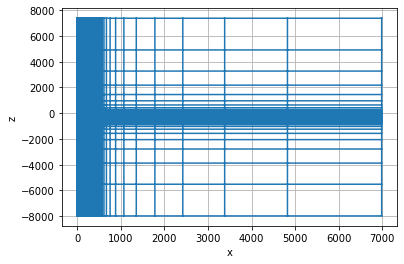

In [10]:
ax = mesh.plot_grid()

In [11]:
def get_casing_inds(ca):
    inds_casing_x = (
        (mesh.cell_centers[:, 0] > ca) & 
        (mesh.cell_centers[:, 0] < casing_b)
    )
    inds_casing_z = (
        (mesh.cell_centers[:, 2] < 0) &
        (mesh.cell_centers[:, 2] > -casing_l)
    )
    return inds_casing_x & inds_casing_z

In [12]:
def plot_casing(ax, model): 
    xlim = 0.22*np.r_[-1, 1]
    zlim = np.r_[-700, 50]
    pcolor_opts={"norm":LogNorm(), "cmap":"Spectral_r"}
    out = casing_sim.view.plot_slice(
        mesh, model, pcolor_opts=pcolor_opts, ax=ax,
    )
    # out[-1].set_label("conductivity (S/m)")
    ax.set_xlim(xlim)
    ax.set_ylim(zlim)

    ax.set_xlabel("x (m)")
    ax.set_ylabel("z (m)")
    return ax

/home/lheagy/git/simpeg/discretize/discretize/base/base_tensor_mesh.py:1025: FutureWarning: hx has been deprecated, please access as mesh.h[0]
  warnings.warn(
/home/lheagy/git/simpeg/discretize/discretize/base/base_tensor_mesh.py:1059: FutureWarning: hz has been deprecated, please access as mesh.h[2]
  warnings.warn(
/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:140: FutureWarning: CylMesh has been deprecated, please use CylindricalMesh. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:182: FutureWarning: CylindricalMesh.isSymmetric has been deprecated, please use CylindricalMesh.is_symmetric. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:217: FutureWarning: CylMesh.plotImage has been deprecated, please use CylMesh.plot_image. It will be removed in version 1.0.0

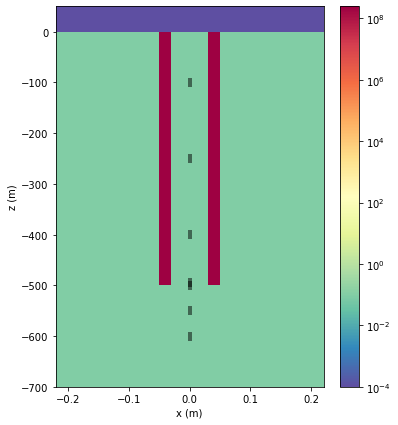

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(6, 7))

key = "conductive_casing_2.50e+08_2.00e-02"

plot_casing(ax, models[key]["sigma"])

for loc in src_z:
    ax.plot(np.r_[0, 0], loc + src_dz/2*np.r_[-1, 1], "-k", lw=4, alpha=0.5)

## set up the simulations

In [14]:
def generate_simulation(mur):
    src_list = []
    for loc in src_z:
        src_locations = np.array([
            [0, 0, loc+src_dz/2.],
            [0, 0, loc-src_dz/2.]
        ])
        for f in frequencies: 
            src = fdem.sources.LineCurrent([], location=src_locations, frequency=f)
            src_list.append(src)
        
    survey = fdem.Survey(src_list)
    sim = fdem.simulation.Simulation3DMagneticField(
        mesh=mesh, sigmaMap=maps.IdentityMap(mesh),
        survey=survey, solver=Pardiso, mu=mur * mu_0
    #     verbose=True
    )
    return sim


In [15]:
def load_fields(name, conductivity, mur):
    solution = np.load(f"{directory}/fields_{name}.npy")
    sim = generate_simulation(mur)
    sim.model = conductivity
    f = sim.fieldsPair(sim)
    f[:, sim._solutionType] = solution
    return f

# choose models to focus on

In [16]:
len(frequencies)

41

In [17]:
casing_t_inv = np.r_[5e-3]
mur_inv = np.r_[1, 50, 100, 150, 200]
freq_inds_inv = np.arange(0, 31, 1)
src_ind_inv = 5

inv_keys = []
for t in casing_t_inv:
    for mur in mur_inv:
        inv_keys.append(f"casing_{mur}_{t:1.2e}")
inv_keys

['casing_1_5.00e-03',
 'casing_50_5.00e-03',
 'casing_100_5.00e-03',
 'casing_150_5.00e-03',
 'casing_200_5.00e-03']

In [18]:
frequencies[freq_inds_inv]

array([  0.1       ,   0.12589254,   0.15848932,   0.19952623,
         0.25118864,   0.31622777,   0.39810717,   0.50118723,
         0.63095734,   0.79432823,   1.        ,   1.25892541,
         1.58489319,   1.99526231,   2.51188643,   3.16227766,
         3.98107171,   5.01187234,   6.30957344,   7.94328235,
        10.        ,  12.58925412,  15.84893192,  19.95262315,
        25.11886432,  31.6227766 ,  39.81071706,  50.11872336,
        63.09573445,  79.43282347, 100.        ])

In [19]:
fields = {}
for key in inv_keys:
    # if key not in fields.keys():
    fields[key] = load_fields(key, models[key]["sigma"], models[key]["mur"])

/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:182: FutureWarning: CylindricalMesh.edgeCurl has been deprecated, please use CylindricalMesh.edge_curl. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)


In [20]:
rcParams["font.size"] = 13

In [21]:
fields.keys()

dict_keys(['casing_1_5.00e-03', 'casing_50_5.00e-03', 'casing_100_5.00e-03', 'casing_150_5.00e-03', 'casing_200_5.00e-03'])

In [22]:
def skin_depth(f, sigma, mur):
    return np.sqrt(2/(2*np.pi*f*sigma*mur*mu_0))

In [23]:
rx_x = np.linspace(100, 500, 17)
rx_z = np.r_[-mesh.h[2].min()/2]
rx_x

array([100., 125., 150., 175., 200., 225., 250., 275., 300., 325., 350.,
       375., 400., 425., 450., 475., 500.])

In [24]:
def create_receivers():
    rx_e_re = fdem.receivers.PointElectricField(
        locations=discretize.utils.ndgrid(rx_x, np.r_[0], rx_z),
        orientation="x",
        component="real",
    )
    rx_e_im = fdem.receivers.PointElectricField(
        locations=discretize.utils.ndgrid(rx_x, np.r_[0], rx_z),
        orientation="x",
        component="imag",
    )
    return rx_e_re, rx_e_im

In [25]:
rx_e_re, rx_e_im = create_receivers()
P = rx_e_re.getP(mesh, "Fx")

/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:217: FutureWarning: CylindricalMesh.getInterpolationMat has been deprecated, please use CylindricalMesh.get_interpolation_matrix. It will be removed in version 1.0.0 of discretize.
  warnings.warn(


In [26]:
k = inv_keys[0]
field = fields[k][:, "e"]

/home/lheagy/git/simpeg/discretize/discretize/base/base_tensor_mesh.py:1042: FutureWarning: hy has been deprecated, please access as mesh.h[1]
  warnings.warn(
/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:182: FutureWarning: CylindricalMesh.area has been deprecated, please use CylindricalMesh.face_areas. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:182: FutureWarning: CylindricalMesh.vol has been deprecated, please use CylindricalMesh.cell_volumes. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)


In [27]:
# get data_vectors
dobs_dict = {}

for k in inv_keys:
    field = fields[k][:, "e"]
    tmp_dict = {}
    for indf in freq_inds_inv:
        si = src_ind_inv*len(frequencies) + indf
        e = field[:, si]
        edata = P * e
        tmp_dict[frequencies[indf]] = {
            "real": edata.real,
            "imag": edata.imag
        }
    dobs_dict[k] = tmp_dict
        

In [28]:
def plot_pos_neg_log(x, y, ax, plot_type="semilogy", ls=None, color=None, marker=None, label=None):
    if plot_type == "plot":
        return ax.plot(x, y, color=color, label=label)
    else:
        inds_pos = (y > 0)
        
        inds_switch = np.where(np.diff(inds_pos))[0].astype(int)+1
        starting_inds = np.hstack([np.r_[0], inds_switch])
        ending_inds = np.hstack([inds_switch, np.r_[len(inds_pos)]])
        
        if ls is None:
            pos_ls = "-"
            neg_ls = "--"
        else:
            pos_ls = "-."
            neg_ls = ":"
        
        if marker is True: 
            marker_pos = "o"
            marker_neg = "s"
        else: 
            marker_pos = None
            marker_neg = None
            
        for start, end in zip(starting_inds, ending_inds):
            xvals = x[start:end]
            yvals = y[start:end]
            if np.all(yvals <= 0):
                getattr(ax, plot_type)(xvals, np.abs(yvals), neg_ls, marker=marker_neg, color=color)
            else: 
                getattr(ax, plot_type)(xvals, yvals, pos_ls, marker=marker_pos, color=color, label=label)
                label=None
        return ax

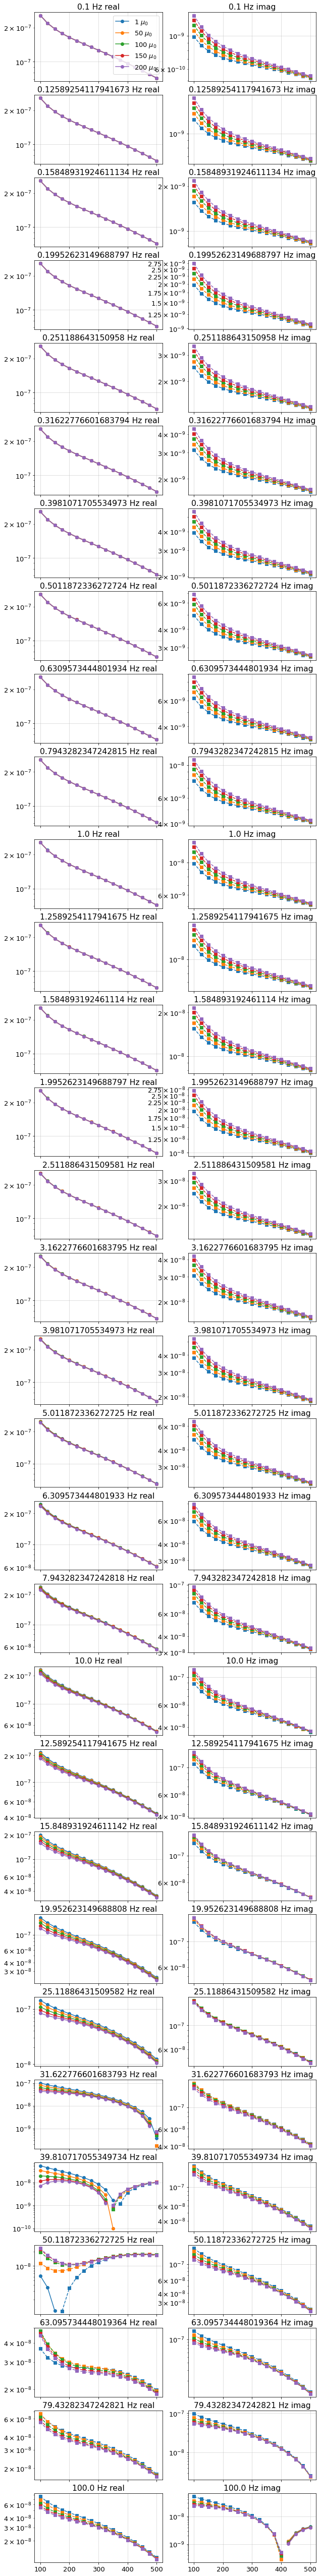

In [29]:
fig, ax = plt.subplots(len(freq_inds_inv), 2, figsize=(10, len(freq_inds_inv)*3), sharex=True)

for i, key in enumerate(inv_keys):
    dobs = dobs_dict[key]
    for j, freq in enumerate(dobs.keys()):
        dobs_freq = dobs[freq]
        for k, reim in enumerate(dobs_freq.keys()):
            label = f"{key.split('_')[1]} $\mu_0$"
            plot_pos_neg_log(
                rx_x, dobs_freq[reim], ax[j, k], marker=True, color=f"C{i}", label=label, plot_type="semilogy"
            )
            ax[j, k].grid("both", alpha=0.5)
            ax[j, k].set_title(f"{freq} Hz {reim}")
ax[0, 0].legend()      


In [77]:
def get_amplitude_phase(real, imag):
    # real = f.real
    # imag = f.imag
    amplitude = np.sqrt(real**2 + imag**2)
    phase = 180/np.pi*np.arctan2(imag, real)
    return amplitude, phase

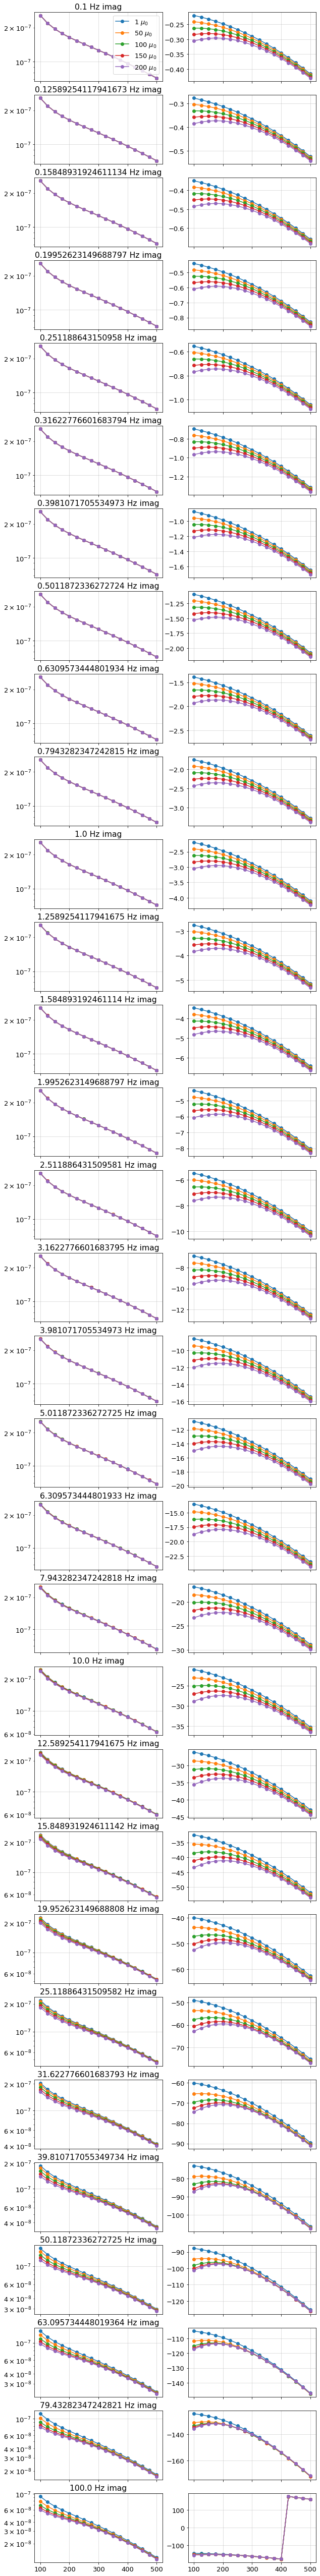

In [78]:
fig, ax = plt.subplots(len(freq_inds_inv), 2, figsize=(10, len(freq_inds_inv)*3), sharex=True)

for i, key in enumerate(inv_keys):
    dobs = dobs_dict[key]
    for j, freq in enumerate(dobs.keys()):
        dobs_freq = dobs[freq]
        amplitude, phase = get_amplitude_phase(dobs_freq["real"], dobs_freq["imag"])
        label = f"{key.split('_')[1]} $\mu_0$"

        plot_pos_neg_log(
            rx_x, amplitude, ax[j, 0], marker=True, color=f"C{i}", label=label, plot_type="semilogy"
        )
        ax[j, 1].plot(rx_x, phase, "-o", color=f"C{i}")
        ax[j, 0].grid("both", alpha=0.5)
        ax[j, 1].grid("both", alpha=0.5)
        ax[j, 0].set_title(f"{freq} Hz {reim}")
ax[0, 0].legend()      


# set up mappings and simulation

In [30]:
def create_maps(true_inds=False, casing_t_ind=0):
    indsx = (mesh.cell_centers[:, 0] < casing_b)
    if true_inds is True: 
        indsx = indsx & (mesh.cell_centers[:, 0] > casing_b - casing_t[casing_t_ind])
    
    inds_interior = (
        indsx &
        (mesh.cell_centers[:, 2] <= 0) &
        (mesh.cell_centers[:, 2] >= -casing_l)
    )

    active_inds_sigma = maps.InjectActiveCells(
        mesh, indActive=inds_interior, 
        valInactive=np.log(models[inv_keys[0]]["sigma"][~inds_interior])
    )

    active_inds_mur = maps.InjectActiveCells(
        mesh, indActive=inds_interior, 
        valInactive=models[inv_keys[0]]["mur"][~inds_interior]
    )

    projection_sigma = maps.SurjectUnits(indices=[np.ones(inds_interior.sum(), dtype=bool)])
    projection_mu = maps.SurjectUnits(indices=[np.ones(inds_interior.sum(), dtype=bool)])

    exp_map = maps.ExpMap(mesh)
    mur_map = maps.MuRelative(mesh)

    sigma_map = exp_map * active_inds_sigma * projection_sigma
    mu_map = mur_map * active_inds_mur * projection_mu

    return sigma_map, mu_map

In [31]:
def create_survey(freq): 
    loc = src_z[src_ind_inv]
    src_locations = np.array([
        [0, 0, loc+src_dz/2.],
        [0, 0, loc-src_dz/2.]
    ])

    rx_e_re, rx_e_im = create_receivers()
    src = fdem.sources.LineCurrent([rx_e_re, rx_e_im], location=src_locations, frequency=freq)
    return fdem.Survey([src])

In [32]:
# create the simulation
def create_simulation(survey, invert_mu=True, true_inds=False):
    wires = maps.Wires(("sigma", 1), ("mu", 1))
    sigma_map, mu_map = create_maps(true_inds)

    if invert_mu is True: 
        sim = fdem.simulation.Simulation3DCurrentDensity(
            mesh, survey=survey, solver=Pardiso, 
            sigmaMap=sigma_map * wires.sigma,
            muMap=mu_map * wires.mu 
        )
    else: 
        sim = fdem.simulation.Simulation3DCurrentDensity(
            mesh, survey=survey, solver=Pardiso, 
            sigmaMap=sigma_map
        )
    return sim


# set up inversions

In [33]:
class SaveInversionProgress(directives.InversionDirective):
    """
    A custom directive to save items of interest during the course of an inversion
    """
    
    results_file = None
    
    def initialize(self):
        """
        This is called when we first start running an inversion
        """
        # initialize an empty dictionary for storing results 
        self.inversion_results = {
            "iteration":[],
            "phi_d":[],
            "dpred":[],
            "logsigma":[],
            "mur":[]
        }

    def endIter(self):
        """
        This is run at the end of every iteration. So here, we just append 
        the new values to our dictionary
        """
        
        # Save the data
        self.inversion_results["iteration"].append(self.opt.iter)
        self.inversion_results["phi_d"].append(self.invProb.phi_d)
        self.inversion_results["dpred"].append(self.invProb.dpred)
        self.inversion_results["logsigma"].append(self.invProb.model[0])
        self.inversion_results["mur"].append(self.invProb.model[0])
        
        if self.results_file is not None: 
            with open(f"{self.results_file}", "wb") as fp:
                pickle.dump(self.inversion_results, fp)
        
        

In [34]:
def create_inversion(
    key, freq, invert_mu=True, relative_error=None, noise_floor=None,
    maxIter=10, maxIterCG=30, maxIterLS=20, true_casing_inds=False, 
):
    # create the simulation
    survey = create_survey(freq)
    dobsvec = np.hstack(list(dobs_dict[key][freq].values()))
    dobs = data.Data(
        survey=survey, dobs=dobsvec, relative_error=relative_error, noise_floor=noise_floor
    )

    sim = create_simulation(survey, invert_mu, true_casing_inds)
    dmis = data_misfit.L2DataMisfit(data=dobs, simulation=sim)

    if invert_mu is True: 
        reg = regularization.Small(mesh=discretize.TensorMesh([2]))
        opt = optimization.ProjectedGNCG(
            maxIter=maxIter, lower=np.r_[-np.inf, 1], 
            maxIterCG=maxIterCG, maxIterLS=maxIterLS,
            tolF=1e-3, tolX=1e-3,
        )
    else: 
        reg = regularization.Small(mesh=discretize.TensorMesh([1]))
        opt = optimization.ProjectedGNCG(
            maxIter=maxIter, lower=np.r_[-np.inf], 
            maxIterCG=maxIterCG, maxIterLS=maxIterLS,
            tolF=1e-3, tolX=1e-3,
        )

    inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt, beta=0)

    # directives
    target_misfit = directives.TargetMisfit(chifact=1)
    
    if true_casing_inds:
        filename_save = f"inv_{key}_{freq:1.0f}_{invert_mu}_true_casing.pkl"
    else: 
        filename_save = f"inv_{key}_{freq:1.0f}_{invert_mu}.pkl"
    inversion_progress = SaveInversionProgress(results_file=f"{directory}/{filename_save}")
    
    # inversion 
    inv = inversion.BaseInversion(inv_prob, [target_misfit, inversion_progress])
    
    return inv

# experiment 1: invert for "equivalent conductivity" of hollow casing



In [35]:
inv_dict_hollow = {}
relative_error = 0.05
noise_floor = 1e-9

for key in inv_keys:
    tmp = {}
    for freq in frequencies[freq_inds_inv]:
        tmp[freq] = {
            invert_mu: create_inversion(
                key, freq, invert_mu=invert_mu, relative_error=relative_error, noise_floor=noise_floor, 
                true_casing_inds=True
            )
            for invert_mu in [False]
        }
    inv_dict_hollow[key] = tmp

In [36]:
mrec_dict_hollow = {}

for key, inv_dict_freq in inv_dict_hollow.items():
    tmp = {}
    for i, freq in enumerate(inv_dict_freq.keys()):
        inv_dict_mu = inv_dict_freq[freq]
        print(f"\n\n------------------------ {key} : {freq} Hz -------------------------- \n")
        # if len(tmp.keys()) == 0: 
        m0 = np.r_[np.log(sigma_casing)]
        # else: 
        #     m0 = tmp[frequencies[freq_inds_inv[i-1]]][False]
        tmp[freq] = {
            invert_mu: inv.run(m0) 
            for invert_mu, inv in inv_dict_mu.items()
        }
        print(tmp[freq])
    mrec_dict_hollow[key] = tmp



------------------------ casing_1_5.00e-03 : 0.1 Hz -------------------------- 

SimPEG.InvProblem will set Regularization.mref to m0.

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0


/home/lheagy/.conda/envs/casing/lib/python3.9/site-packages/pymatsolver/direct.py:23: PardisoTypeConversionWarning: Converting csc_matrix matrix to CSR format, will slow down.
  self.solver = MKLPardisoSolver(


=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  0.00e+00  7.23e-10  0.00e+00  7.23e-10    9.75e-06      0              
------------------------- STOP! -------------------------
0 : |fc-fOld| = 1.0000e+00 <= tolF*(1+|f0|) = 0.0000e+00
0 : |xc-x_last| = 1.0000e+00 <= tolX*(1+|x0|) = 0.0000e+00
1 : |proj(x-g)-x|    = 9.7479e-06 <= tolG          = 1.0000e-01
1 : |proj(x-g)-x|    = 9.7479e-06 <= 1e3*eps       = 1.0000e-02
0 : maxIter   =      10    <= iter          =      0
------------------------- DONE! -------------------------
{False: array([15.42494847])}


------------------------ casing_1_5.00e-03 : 0.12589254117941673 Hz -------------------------- 

SimPEG.InvProblem will set Regularization.mref to m0.

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2D

/home/lheagy/.conda/envs/casing/lib/python3.9/site-packages/pymatsolver/direct.py:73: PardisoTypeConversionWarning: Converting csc_matrix matrix to CSR format, will slow down.
  self.solver.refactor(self.A)


------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 1.0111e-03
1 : |xc-x_last| = 0.0000e+00 <= tolX*(1+|x0|) = 1.6425e-02
1 : |proj(x-g)-x|    = 7.1619e-02 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 7.1619e-02 <= 1e3*eps       = 1.0000e-02
0 : maxIter   =      10    <= iter          =      1
------------------------- DONE! -------------------------
{False: array([15.42494847])}


------------------------ casing_50_5.00e-03 : 0.12589254117941673 Hz -------------------------- 

SimPEG.InvProblem will set Regularization.mref to m0.

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x

In [37]:
def get_inversion_result_dict(inv):
    return inv.directiveList.dList[-1].inversion_results

In [38]:
def plot_obs_pred(inv_dict, key, freq, invert_mu=True, ax=None, color_ind=0, label=None):
    if ax is None: 
        fig, ax = plt.subplots(3, 2, figsize=(12, 8))
    
    dobs = dobs_dict[key][freq]
    dpred = get_inversion_result_dict(inv_dict[key][freq][invert_mu])["dpred"][-1]
    
    ax[0, 0].semilogy(rx_x, np.abs(dobs["real"]), "o", color=f"C{color_ind}", label=f"{label} obs")
    ax[0, 0].semilogy(rx_x, np.abs(dpred[:len(rx_x)]), "-", color=f"C{color_ind}", label=f"{label} pred")

    ax[0, 1].semilogy(rx_x, np.abs(dobs["imag"]), "o", color=f"C{color_ind}")
    ax[0, 1].semilogy(rx_x, np.abs(dpred[len(rx_x):]), "-", color=f"C{color_ind}")

    diff = np.hstack(list(dobs.values())) - dpred
    ax[1, 0].semilogy(rx_x, np.abs(diff[:len(rx_x)]), "-", label="diff", color=f"C{color_ind}")
    ax[1, 1].semilogy(rx_x, np.abs(diff[len(rx_x):]), "-", label="diff", color=f"C{color_ind}")

    ax[2, 0].semilogy(rx_x, np.abs(diff[:len(rx_x)])/np.abs(dobs["real"])*100, "-", color=f"C{color_ind}")
    ax[2, 1].semilogy(rx_x, np.abs(diff[len(rx_x):])/np.abs(dobs["imag"])*100, "-", color=f"C{color_ind}")

    for a in ax.flatten():
        a.grid("both", alpha=0.5)
    return ax

In [39]:
inv_dict_hollow.keys()

dict_keys(['casing_1_5.00e-03', 'casing_50_5.00e-03', 'casing_100_5.00e-03', 'casing_150_5.00e-03', 'casing_200_5.00e-03'])

100.0


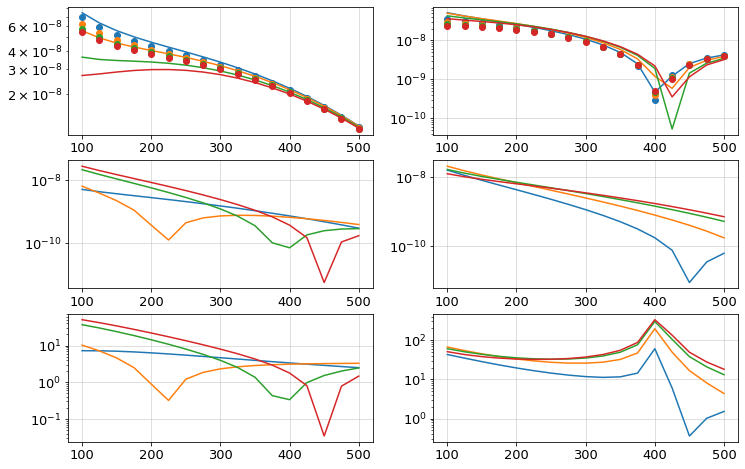

In [40]:
ind_mur_plot = 4
ind_freq_plot = 30
print(frequencies[freq_inds_inv[ind_freq_plot]])

fig, ax = plt.subplots(3, 2, figsize=(12, 8))

for i, key in enumerate(list(inv_dict_hollow.keys())[1:]): 
    label = f"{key.split('_')[1]} $\mu_0$"
    plot_obs_pred(
        inv_dict_hollow, key,  
        frequencies[freq_inds_inv[ind_freq_plot]], False, 
        ax=ax, color_ind=i, label=label
    )
# ax[0, 0].legend()

In [41]:
mrec_dict_hollow.keys()

dict_keys(['casing_1_5.00e-03', 'casing_50_5.00e-03', 'casing_100_5.00e-03', 'casing_150_5.00e-03', 'casing_200_5.00e-03'])

In [42]:
inv_results = get_inversion_result_dict(inv_dict_hollow[list(mrec_dict_hollow.keys())[1]][10][False])

In [43]:
inv_results["phi_d"][-1]

3.3272735537223994

In [44]:
chifact_plot = 7
phid_plot = len(rx_x)*chifact_plot
phid_plot

119

In [45]:
phi_d_star = len(rx_x)

In [46]:
tmp = ax[0]

(-0.2, 5.0)

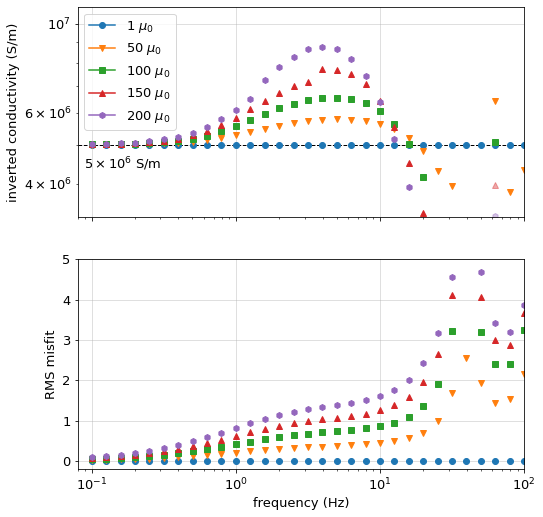

In [75]:
fig, ax = plt.subplots(2,1, sharex=True, figsize=(8, 8.5)) 

xlim = np.r_[8e-2, 100]
ax[0].hlines(sigma_casing, xmin=xlim.min(), xmax=xlim.max(),color="k", ls="--", lw=1) 
ax[0].text(xlim.min()*1.1, sigma_casing/1.15, f"$5\\times 10^6$ S/m")
markers = ["o", "v", "s", "^", "h"]

for i, key in enumerate(list(mrec_dict_hollow.keys())):
    for f, val in mrec_dict_hollow[key].items():
        phi_d = inv_dict_hollow[key][f][False].invProb.phi_d
        
        if phi_d <= phid_plot: 
            alpha = 1
        else: 
            alpha = 0.4
              
        ax[0].loglog(
            f, np.exp(val[False]), f"C{i}", alpha=alpha, 
            label=f"{key.split('_')[1]} $\mu_0$" if f==frequencies[freq_inds_inv[0]] else None,
            marker=markers[i],
        )
        
        ax[1].semilogx(
            f, np.sqrt(phi_d/phi_d_star), f"C{i}", marker=markers[i],
        )
ax[0].set_ylim(3.3e6, 1.1e7)
ax[0].set_xlim(xlim)
ax[0].set_ylabel("inverted conductivity (S/m)")
ax[0].legend(loc=2)

for a in ax: 
    a.grid("both", alpha=0.5)
ax[1].set_xlabel("frequency (Hz)")
ax[1].set_ylabel("RMS misfit")
ax[1].set_ylim([-0.2, 5])

       

In [69]:
def skin_depth(freq, sigma, mur):
    return np.sqrt(2 / (2*np.pi*freq*sigma*mur*mu_0))

In [70]:
def skin_depth_freq(delta, sigma, mur):
    return 2 / (2*np.pi * delta**2 * mur* mu_0 * sigma)

In [74]:
for mur in mur_inv:
    print(f"{mur:4.0f} mu0:  {skin_depth_freq(casing_t_inv[0], sigma_casing, mur):5.0f} Hz")

   1 mu0:   2026 Hz
  50 mu0:     41 Hz
 100 mu0:     20 Hz
 150 mu0:     14 Hz
 200 mu0:     10 Hz


# experiment 2: invert for solid cylinder conductivity, permeability 

In [48]:
# inv_dict = {}
# relative_error = 0.02
# noise_floor = 1e-11

# for key in inv_keys:
#     tmp = {}
#     for freq in frequencies[freq_inds_inv]:
#         tmp[freq] = {
#             invert_mu: create_inversion(
#                 key, freq, invert_mu=invert_mu, relative_error=relative_error, noise_floor=noise_floor,
#             )
#             for invert_mu in [True, False]
#         }
#     inv_dict[key] = tmp

In [49]:
# t = casing_t_inv[0]
# sigdc = sigma_casing * (1-(casing_b-t)**2/casing_b**2)
# sigstart = sigma_casing

# starting_models = {
#     True: np.r_[np.log(sigstart), 1],
#     False: np.r_[np.log(sigstart)]
# }

In [50]:
# mrec_dict = {}

# for key, inv_dict_freq in inv_dict.items():
#     tmp = {}
#     for freq, inv_dict_mu in inv_dict_freq.items():
#         print(f"\n\n------------------------ {key} : {freq} Hz -------------------------- \n")
#         tmp[freq] = {
#             invert_mu: inv.run(starting_models[invert_mu]) 
#             for invert_mu, inv in inv_dict_mu.items()
#         }
#         print(tmp[freq])
#     mrec_dict[key] = tmp

In [51]:
# fig, ax = plt.subplots(1,1) 

# for i, key in enumerate(mrec_dict.keys()):
#     for f, val in mrec_dict[key].items():
#         ax.loglog(
#             f, np.exp(val[False]), f"C{i}o", 
#             label=f"{key.split('-')[1]} $\mu_0$" if f==frequencies[freq_inds_inv[0]] else None
#         )
        

In [52]:
# key = "casing_1_1.00e-02"
# freq = frequencies[freq_inds_inv[0]]

# plot_obs_pred(key, freq, False);